In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import missingno as msno

# 2. 전처리
## 2-1. 결측치 처리
- 0이나 특정 상수로 대치, 대푯값, 단순확률대치법, 다른 변수들로부터 모델링햐여 결측값 예측, 결측값 여부를 새로운 특징으로 추출, 보간법(시계열)
- 데이터 양에 비해 결측치가 극소수이거나, 절대다수인 경우 결측치가 있는 행이나 열 자체를 삭제하기도 함

### 결측치 확인

In [2]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

print(wine.isna().sum())

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64


In [3]:
# 임의 결측치 데이터 생성
from numpy.random import randint
wine_m = wine.copy()
for col in ['Alcohol', 'Ash']:
    random_idx = randint(0, len(wine), 25)
    wine_m.loc[random_idx, col] = np.nan
print(wine_m.isna().sum())

Alcohol      25
Malicacid     0
Ash          24
Magnesium     0
Hue           0
dtype: int64


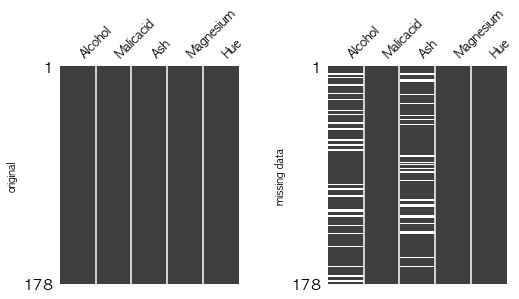

In [4]:
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.family'] = "AppleGothic"
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, ax = plt.subplots(1,2, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

msno.matrix(df=wine, figsize=(5,5), fontsize=12, ax=ax[0], sparkline=False)
ax[0].set_ylabel("original");

msno.matrix(df=wine_m, figsize=(5,5), fontsize=12, ax=ax[1], sparkline=False)
ax[1].set_ylabel("missing data");

plt.show()

### Zero imputation & Constant imputation

In [5]:
wine_m[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,NaN,NaN
7,14.06,2.61
8,14.83,2.17
9,NaN,2.27


In [6]:
wine_imp = wine_m.fillna(0)
wine_imp[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,0.00,0.00
7,14.06,2.61
8,14.83,2.17
9,0.00,2.27


### 대푯값으로 채우는 방법
- 해당 변수의 결측되지 않은 다른 값들로 구한 평균값, 중앙값, 최빈값 등의 대푯값으로 결측치 대치
- 로그 변환 등을 통해 치우침이 적은 분포로 데이터 변환 후, 대푯값 구해 대치

In [7]:
wine_m[['Alcohol', 'Ash']].head(10)

,Alcohol,Ash
0,14.23,2.43
1,13.20,2.14
2,13.16,2.67
3,14.37,2.50
4,13.24,2.87
5,14.20,2.45
6,NaN,NaN
7,14.06,2.61
8,14.83,2.17
9,NaN,2.27


In [8]:
# 결측치를 대표값 'mean'으로 대치
from sklearn.impute import SimpleImputer

# strategy = 'mean', 'median', or 'most_frequent'
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
wine_imp1 = imputer.fit_transform(wine_m)
wine_imp1 = pd.DataFrame(wine_imp1, columns=wine_m.columns)

al_mean = wine_m['Alcohol'].mean()
as_mean = wine_m['Ash'].mean()

print(f'alcohol mean: {al_mean:.2f}, ash mean: {as_mean:.2f}')
print(wine_imp1[['Alcohol', 'Ash']].head(10).round(2))

alcohol mean: 13.00, ash mean: 2.37
   Alcohol   Ash
0    14.23  2.43
1    13.20  2.14
2    13.16  2.67
3    14.37  2.50
4    13.24  2.87
5    14.20  2.45
6    13.00  2.37
7    14.06  2.61
8    14.83  2.17
9    13.00  2.27


### 단순확률대치법
- 유사한 데이터셋에서 랜덤하게 샘플링한 값으로 대치
    - Hot-deck : 현재 진행중인 연구에서 비슷한 성향 데이터 중 랜덤 선택
    - Cold-deck : 외부 출처 혹은 비슷한 연구에서 대체할 데이터 가져오는 것

In [9]:
# Hot-Deck
# wine이 wine_m과 비슷한 성향이라고 가정하고 wine에서 랜덤하게 선택하여 wine_m 대치
wine_imp2 = wine_m.copy()

for feature in ['Alcohol', 'Ash']:
    missing_idx = wine_imp2.loc[wine_imp2[feature].isna()==True].index
    wine_imp2.loc[missing_idx, feature] = wine[feature].sample(len(missing_idx)).values

wine_imp2.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

In [10]:
wine_imp2.head()

,Alcohol,Malicacid,Ash,Magnesium,Hue
0,14.23,1.71,2.43,127,1.04
1,13.20,1.78,2.14,100,1.05
2,13.16,2.36,2.67,101,1.03
3,14.37,1.95,2.50,113,0.86
4,13.24,2.59,2.87,118,1.04


### 다른 변수들로 모델링하여 결측값 예측
- KNN imputer : 정확할 때가 많지만, 전체 데이터셋을 올려야해서 메모리가 많이 필요하고 이상치에 민감, 
- 기타 회귀 및 분류 알고리즘 이용 가능

In [11]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
wine_imp3 = imputer.fit_transform(wine_m)
wine_imp3 = pd.DataFrame(wine_imp3, columns=wine_m.columns)
wine_imp3.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

### 보간법
- 시계열 데이터 결측치 대치 : linear, polynomial, spline
- 맨 앞의 결측치는 보간되지 않으므로 단순하게 다음값으로 채움

In [12]:
wine_imp4 = wine_m.interpolate(method='linear')
wine_imp4.isna().sum()

Alcohol      0
Malicacid    0
Ash          0
Magnesium    0
Hue          0
dtype: int64

### 실제값과 대치값 비교

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature = 'Alcohol'
report = pd.DataFrame({'실제값':wine[feature], "mean대치":wine_imp1[feature],
                      'Hotdeck':wine_imp2[feature], 'KNN':wine_imp3[feature],
                      'linear interpolate':wine_imp4[feature]})

score_report = pd.DataFrame(index=['MAE', 'MSE'])
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report.round(3)

,실제값,mean대치,Hotdeck,KNN,linear interpolate
MAE,0.0,0.089,0.117,0.111,0.062
MSE,0.0,0.077,0.145,0.117,0.038


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature = 'Ash'
report = pd.DataFrame({'실제값':wine[feature], "mean대치":wine_imp1[feature],
                      'Hotdeck':wine_imp2[feature], 'KNN':wine_imp3[feature],
                      'linear interpolate':wine_imp4[feature]})

score_report = pd.DataFrame(index=['MAE', 'MSE'])
for col in report.columns:
    mae = mean_absolute_error(report['실제값'], report[col])
    mse = mean_squared_error(report['실제값'], report[col])
    score_report.loc['MAE', col] = mae
    score_report.loc['MSE', col] = mse

score_report.round(3)

,실제값,mean대치,Hotdeck,KNN,linear interpolate
MAE,0.0,0.022,0.036,0.028,0.027
MSE,0.0,0.006,0.019,0.009,0.010


## 2-2. 이상치 처리
- 이상치 데이터 판정기준

1) ESD : mean-3\*std < data < mean+3\*std 

2) 기하평균 - 2.5 \* std < data < 기하평균 + 2.5 \* std

3) Q1 - 1.5\* IQR < data < Q3 + 1.5\* IQR

4) DBSCAN 통해 -1로 분류되는 값

- 이상치 처리방법 : 절단, 조정, 클리핑

In [15]:
wine = pd.read_csv("https://raw.githubusercontent.com/algoboni/pythoncodebook1-1/main/2-1_wine.csv",
                  index_col=0).filter(['Alcohol', 'Malicacid', 'Ash', 'Magnesium', 'Hue'])

IQR = wine['Malicacid'].quantile(0.75) - wine['Malicacid'].quantile(0.25)
top = wine['Malicacid'].quantile(0.75) + IQR * 1.5
down = wine['Malicacid'].quantile(0.25) - IQR * 1.5

out_id = wine.loc[(wine['Malicacid']>=top) | (wine['Malicacid']<=down)].index
print("이상치 index", out_id)

이상치 index Int64Index([123, 137, 173], dtype='int64')


### 절단
- 절단 후 새로운 이상치 생길 수 있으나 이는 분석가가 상황에 맞게 설정 필요

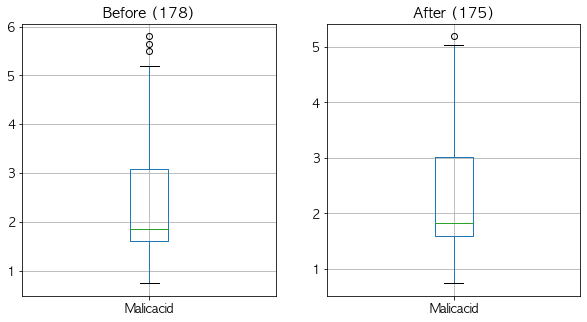

In [16]:
prep_df = wine[['Malicacid']].drop(out_id, axis=0)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

### 조정
- 이상치를 앞서 정해진 이상치의 상한과 하한선으로 보정

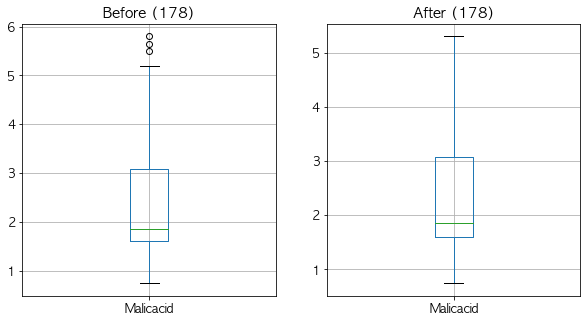

In [17]:
prep_df2 = wine[['Malicacid']].clip(down, top)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df2], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

### 클리핑
- 이상치 상, 하한을 특정값으로 지정하여, 벗어나는 값을 조정
- 이상치 경계값에 대한 확실한 정보를 가지고 있거나, 데이터를 특정 경계값으로 제한하고 싶을 때

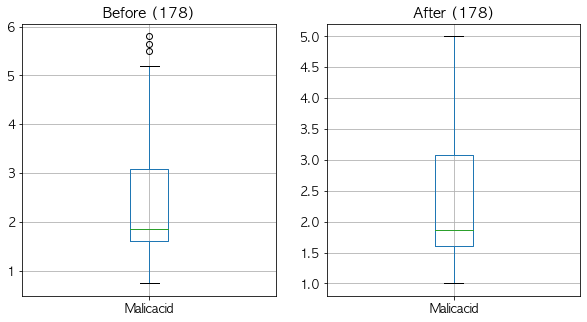

In [18]:
prep_df3 = wine[['Malicacid']].clip(1,5)

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1,2)
for data, ax, title in zip([wine[['Malicacid']], prep_df3], axes, ['Before', 'After']):
    data.boxplot(ax=ax)
    ax.set_title("{} ({})".format(title, len(data)))
plt.show()

## 2-3 클래스 불균형 처리
- 오버샘플링 & 언더샘플링

In [35]:
from sklearn.datasets import load_breast_cancer
from collections import Counter

data = load_breast_cancer()
df = pd.DataFrame(np.c_[data['data'], data['target']], 
                  columns = list(data.feature_names) + ['target'])

df = df.filter(['mean radius', 'mean texture', 'mean area', 'target'])
print("3 front rows: \n", df.head(3), "\n")
print("original data class distribution:", Counter(df['target']))


df1 = df.loc[df['target']==0].sample(50)
df2 = df.loc[df['target']==1].sample(250)
imb_df = pd.concat([df1, df2]).reset_index(drop=True)
print("imbalanced data class distribution: ", Counter(imb_df['target']))

features = imb_df.drop('target', axis=1)
target = imb_df['target']

3 front rows: 
    mean radius  mean texture  mean area  target
0        17.99         10.38     1001.0     0.0
1        20.57         17.77     1326.0     0.0
2        19.69         21.25     1203.0     0.0 

original data class distribution: Counter({1.0: 357, 0.0: 212})
imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})


### 랜덤 오버샘플링
- 기존에 존재하는 소수의 클래스를 단순복제
- 분포의 편화는 없으나 소수 클래스인 데이터가 많아지면서 해당 클래스에 대한 가중치가 높아지게 된다. 한편 단순히 동일 데이터의 증가이므로 과적할 될 수도 있다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


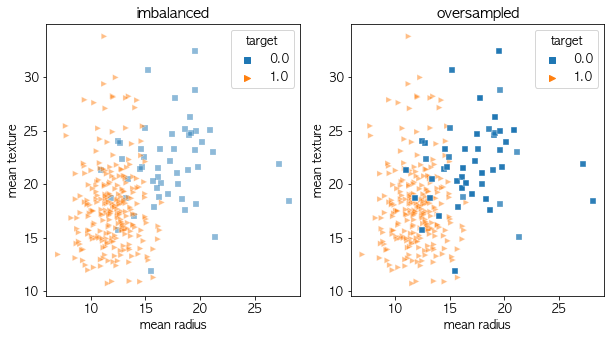

In [44]:
from imblearn.over_sampling import RandomOverSampler

os = RandomOverSampler(random_state=0)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df1 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df1,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);

plt.show()

### SMOTE (synthetic minority oversampling technique)
- 임의의 소수 클래스 데이터로부터 인근 소수 클래스 사이에 새로운 데이터 생성
    - 임의의 소수 클래스 x를 잡고 가장 가까운 k개의 이웃을 찾은 다음, k개의 이웃과 x사이에 임의의 새로운 데이터 x' 생성

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


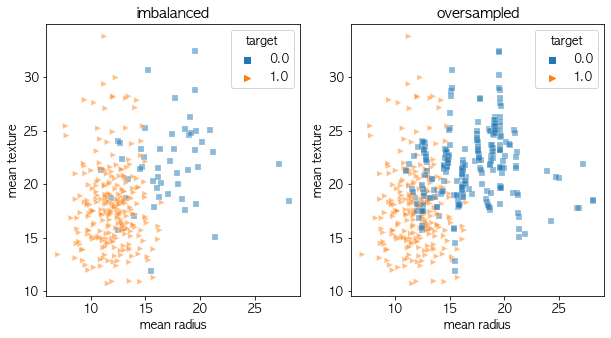

In [53]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df2 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df2,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### Borderline SMOTE
- 다수, 소수의 클래스를 구분하는 선을 그을 때 서로 인접해있는 경계선에 있는 소수 클래스의 데이터에 대해서 SMOTE
    - 임의의 소수 클래스 데이터 x와 근접하는 데이터들의 클래스를 살펴보고 여기에 소수와 다수 클래스가 모두 존재하면 이 데이터를 경계데이터롤 분류한다. 
    - 그렇지 않은 경우 소수 클래스 데이터 x는 고려하지 않는다

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


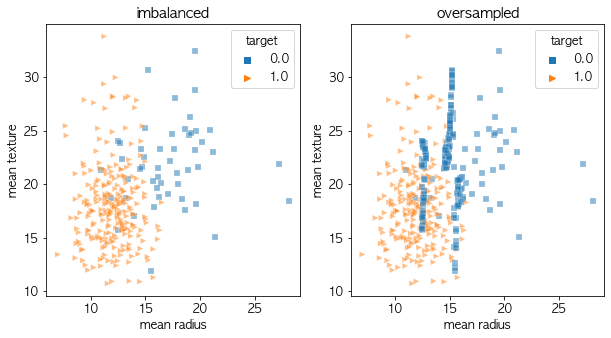

In [49]:
from imblearn.over_sampling import BorderlineSMOTE

os = BorderlineSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df3 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df3,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### K-means SMOTE

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 252, 1.0: 250})


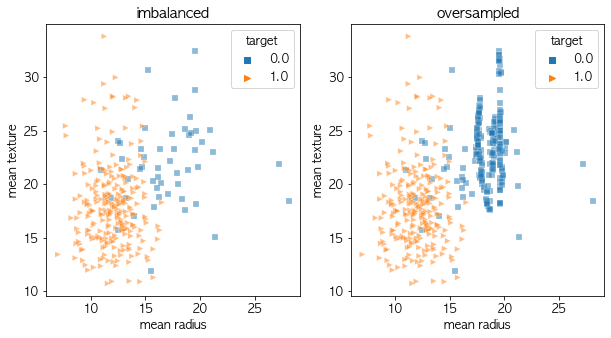

In [52]:
from imblearn.over_sampling import KMeansSMOTE

os = KMeansSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df4 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df4,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()

### SVM SMOTE
- 소수 클래스인 support vector 데이터들을 경계데이터로 삼고 SMOTE 적용

imbalanced data class distribution:  Counter({1.0: 250, 0.0: 50})
oversampled data class distribution:  Counter({0.0: 250, 1.0: 250})


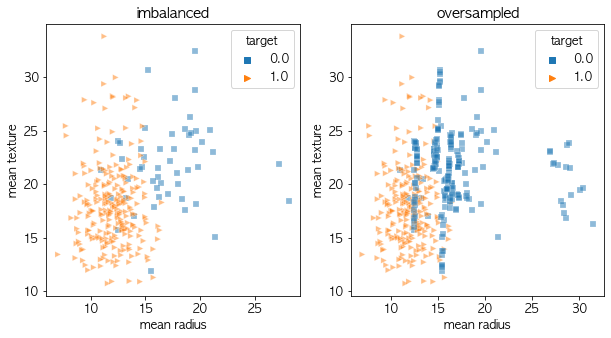

In [54]:
from imblearn.over_sampling import SVMSMOTE
os = SVMSMOTE(random_state=0, k_neighbors=3)
bal_features, bal_target = os.fit_resample(features, target)
print("imbalanced data class distribution: ", Counter(target))
print("oversampled data class distribution: ", Counter(bal_target))

over_df5 = pd.DataFrame(np.c_[bal_features, bal_target], columns = imb_df.columns)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("imbalanced")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=imb_df,
               ax=ax[0], alpha=0.5, style='target', markers=['s', '>']);

ax[1].set_title("oversampled")
sns.scatterplot(x='mean radius', y='mean texture', hue='target', data=over_df5,
               ax=ax[1], alpha=0.5, style='target', markers=['s', '>']);
plt.show()